## Summary

I looked at the dataset by hand and looked at some statistics.

* No classification error found (every video in 'fight' is a video of a fight, and no video in 'fight' contains a fight).
* Some videos are duplicated, we only keep one of the duplicates in the dataset.
* Some videos are very similar (e.g. consecutive clips of a fight). If a model is trained on some clips from a fight and evaluated on other clips of the same fight, it might output correct classification based on the people's clothes. This would not generalize to other videos. We will design train/val splits avoiding this.
* Some properties (unrelated to the presence of a fight) are different between the videos of fights and others: height of the images, frame-per-seconds, frame count, RGB means and variance, encoding algorithm. We will need to be careful to avoid a __[Clever Hans effect](https://en.wikipedia.org/wiki/Clever_Hans#The_Clever_Hans_effect)__.


In [1]:
%load_ext autoreload
%autoreload 2

## List the videos

In [2]:
import os
from pathlib import Path

from fight_classifier import DATASET_DIR
fights_dir = DATASET_DIR / "Peliculas/fights"
no_fights_dir = DATASET_DIR / "Peliculas/noFights"

fights_names = os.listdir(fights_dir)
no_fights_names = os.listdir(no_fights_dir)

fights_paths = [fights_dir / name for name in fights_names]
no_fights_paths = [no_fights_dir / name for name in no_fights_names]
print(f'{len(fights_paths)} fight videos, {len(no_fights_paths)} no-fight videos')

100 fight videos, 101 no-fight videos


## Detect duplicates

We find the following duplicates:
* 'fights/newfi2.avi' and 'fights/newfi1.avi'
* 'fights/newfi72.avi' and 'fights/newfi73.avi'
* 'noFights/93.mpg' and 'noFights/73.mpg'
* 'noFights/94.mpg' and 'noFights/74.mpg'

Visual inspection confirms they are indeed identical (although very unlikely, it is possible to have the same hash with different videos).

In [5]:

from collections import defaultdict
from typing import Dict, List, Mapping

import skvideo.io
import tqdm

unique_fights_paths = []
unique_no_fights_paths = []
hash_to_paths: Mapping[int, List[str]] = defaultdict(list)
    
for path in tqdm.tqdm(fights_paths):
    path_str = str(path)
    video = skvideo.io.vread(path_str)
    video_hash = hash(video.tobytes())
    if video_hash not in hash_to_paths:
        unique_fights_paths.append(path)
    hash_to_paths[video_hash].append(path_str)
    
for path in tqdm.tqdm(no_fights_paths):
    path_str = str(path)
    video = skvideo.io.vread(path_str)
    video_hash = hash(video.tobytes())
    if video_hash not in hash_to_paths:
        unique_no_fights_paths.append(path)
    hash_to_paths[video_hash].append(path_str)

duplicates = {
    video_hash: paths 
    for video_hash, paths in hash_to_paths.items()
    if len(paths) != 1
}

print(f'Duplicates, {duplicates}\n')
print(
    f'{len(unique_fights_paths)} unique fight videos, '
    f'{len(unique_no_fights_paths)} unique no-fight videos')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:54<00:00,  1.87it/s]

Duplicates, {-5530005992208621640: ['/home/matthieu/aviva/hiring-challenge/dataset/Peliculas/fights/newfi2.avi', '/home/matthieu/aviva/hiring-challenge/dataset/Peliculas/fights/newfi1.avi'], 4449316089113810615: ['/home/matthieu/aviva/hiring-challenge/dataset/Peliculas/fights/newfi72.avi', '/home/matthieu/aviva/hiring-challenge/dataset/Peliculas/fights/newfi73.avi'], 6427645079328476313: ['/home/matthieu/aviva/hiring-challenge/dataset/Peliculas/noFights/93.mpg', '/home/matthieu/aviva/hiring-challenge/dataset/Peliculas/noFights/73.mpg'], -3138670080425330190: ['/home/matthieu/aviva/hiring-challenge/dataset/Peliculas/noFights/94.mpg', '/home/matthieu/aviva/hiring-challenge/dataset/Peliculas/noFights/74.mpg']}

98 unique fight videos, 99 unique no-fight videos


## Sort videos in coarse and fine-grained categories

Some videos are clips extracted from the same video. They are extremely similar, and a trivial classifier (e.g. a nearest neighbor classifier using the histogram of colors as the unique feature) would probably classify correctly the second video if the first video was in the training set. It is undesirable, since such a classifier would fail to generalize to completely new videos.

<div>
    <table>
        <tr>
            <td>Those two images come from different videos</td>
            <td>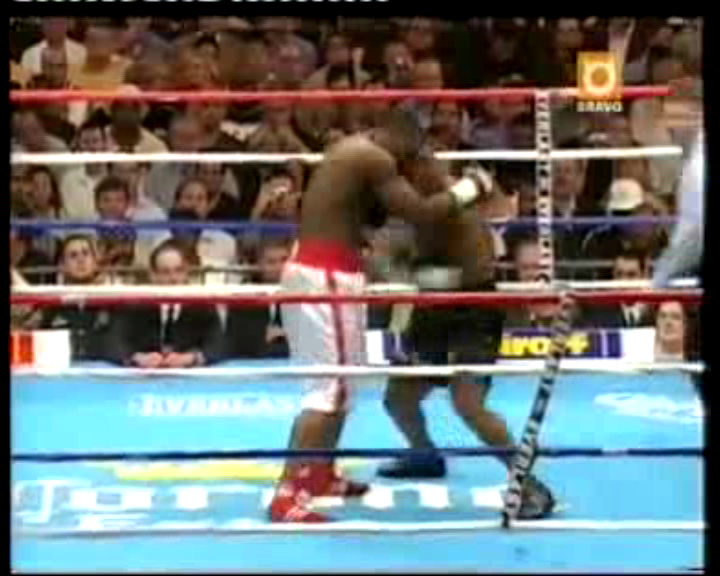</td>
            <td>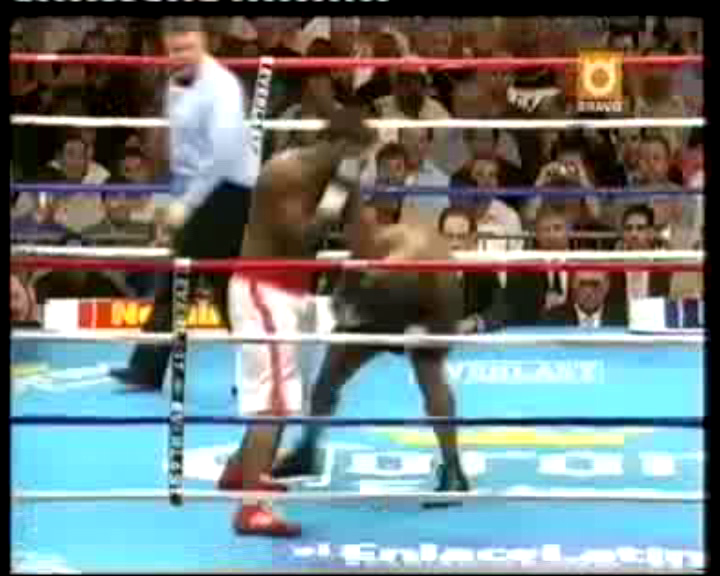</td>
        </tr>
    </table>
</div>

There are some slightly less problematic videos, where the clips show different people but in extremely similar contexts (3 clips of the same soccer game in "fights" without any clip from that game in "noFights", clips of different people walking in the same street in "noFights" without any clip in that street in "fights").

<div>
    <table>
        <tr>
            <td>A classifier could base its decision on the jerseys, or the "mtn" logo.</td>
            <td>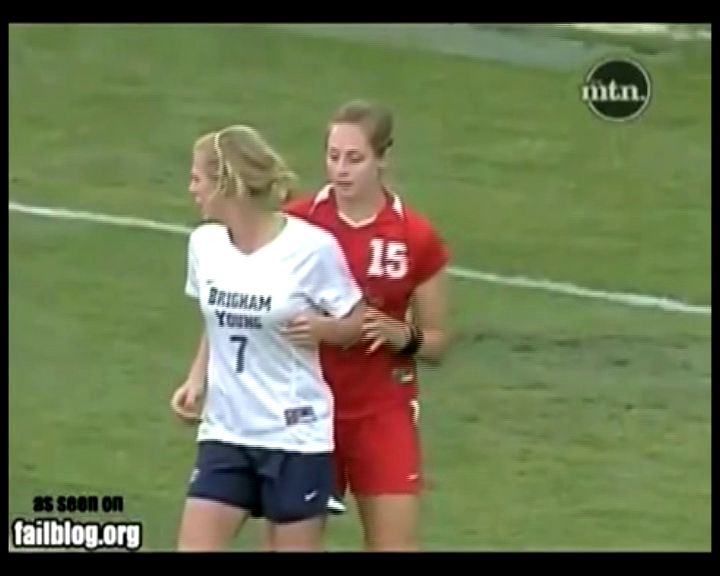</td>
            <td>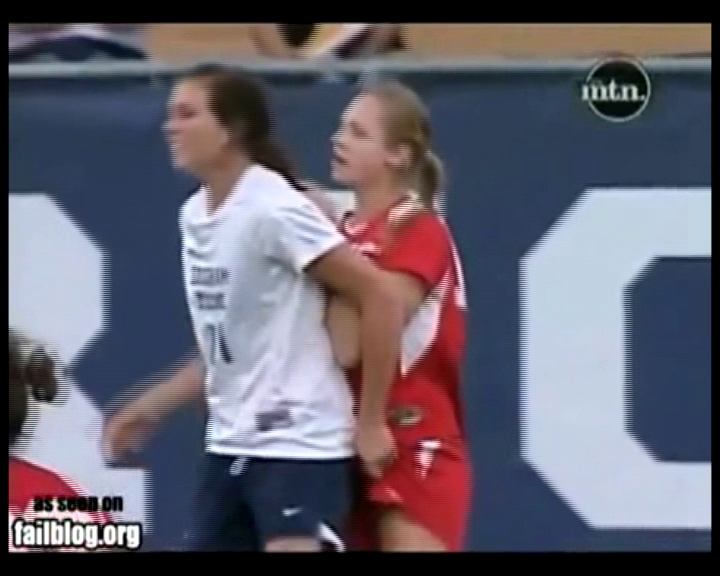</td>
            <td>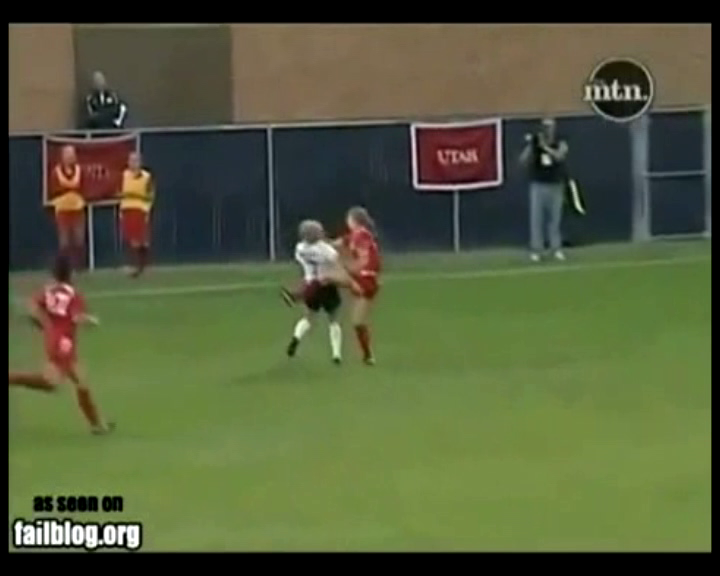</td>
        </tr>
        <tr>
            <td>A classifier could base its decision on the trees in the background.</td>
            <td>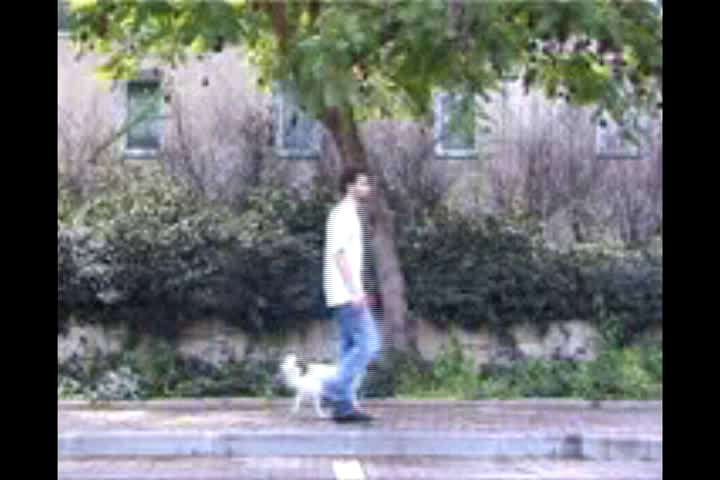</td>
            <td>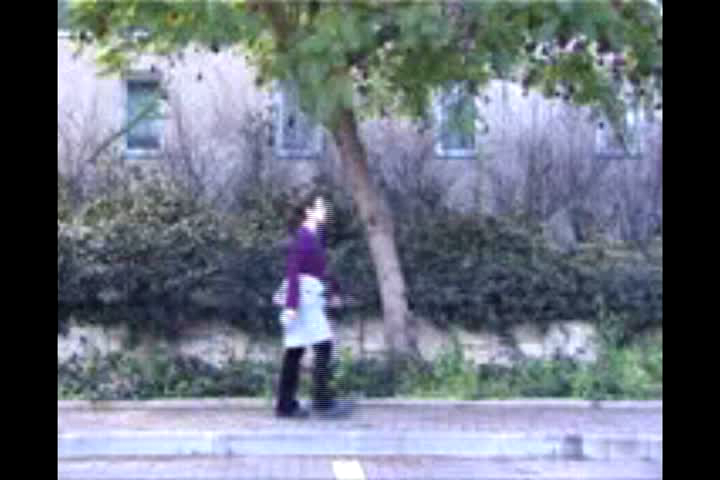</td>
            <td>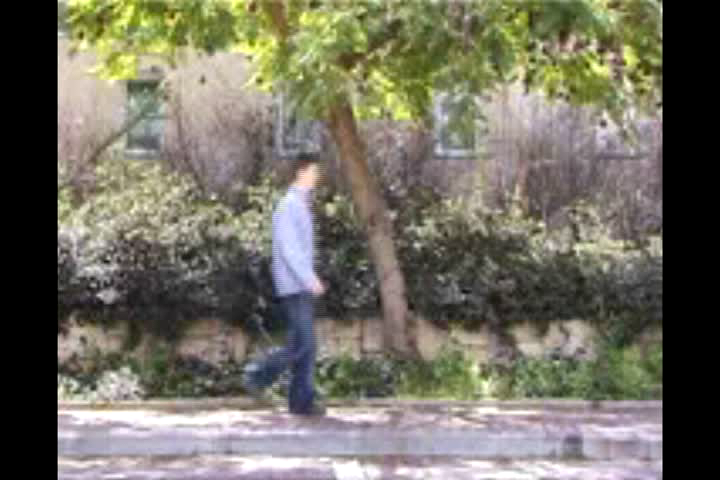</td>
        </tr>
    </table>
</div>

Finally, there are some clips which are similar in a more abstract way. There are clips of people practicing basketball in "noFights", but no clip of a basketball court in "fights".
<div>
    <table>
        <tr>
            <td>A classifier could wrongly decide "basketball --> no fight"</td>
            <td>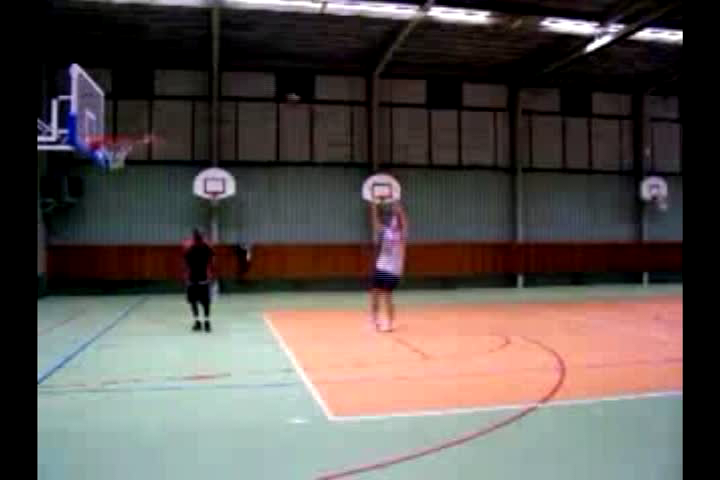</td>
            <td>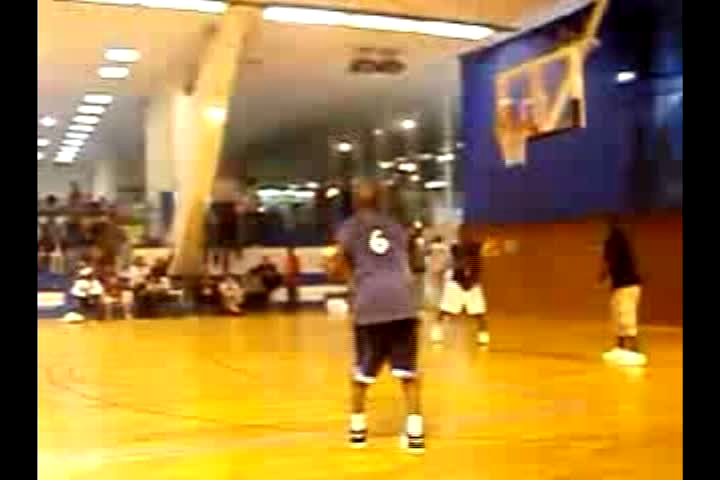</td>
        </tr>
    </table>
</div>

In all of those, the problem is not exactly that the classifier could overfit, and base its decision on features which have nothing to do with the presence of a fight. The problem is that, if our train/val split does not take these into account, we may fail to detect that overfitting.

Imagine we have 4 videos of fights: F1, F1', F2, F2' (with F1 very similar to F1', and F2 very similar to F2'), and 4 videos with no fights: N1, N1', N2, N2'. If you train on F1, F2, N1, N2; and test on F1', F2', N1', N2'. You will likely have a very good validation accuracy (F1' being very similar to F1, the output of a classifier will likely be the same). But that validation accuracy does not reflect the performance of your model on other videos. On the other hand, if you train on F1, F1', N1, N1'; and test on F2, F2', N2, N2', your validation accuracy will probably be terrible (because you need more than 4 examples to train a non-trivial classifier) but it is likely in-line with the performance of your model on other videos.

This is why I organized the dataset in coarse categories ("boxing", "soccer", "someone walking") and fine categories ("this exact person walking in that street", "this particular soccer game",...). The following cell is saving a csv "DATASET_DIR/Peliculas/empty_videos.csv" with empty columns for "coarse_category" and "fine_category". I filled them by hand and saved it into "DATASET_DIR/Peliculas/videos.csv".

The function `split_based_on_column` in `fight_classifier.data.data_split` will allow us to make train/val splits which put all the videos with the same "fine_category" (or "coarse_category") in the same part of the dataset.

In [161]:
import re

import pandas as pd


# We sort the videos by index, to make it easier to manually fill
# the "coarse_category" and "fine_category" columns
fights_re = re.compile('.*/newfi([0-9]+)')
sorted_fights_paths = sorted(
    unique_fights_paths, 
    key=lambda p: int(fights_re.match(str(p)).group(1)))

no_fights_re = re.compile('.*/([0-9]+)')

sorted_no_fights_paths = sorted(
    unique_no_fights_paths,
    key=lambda p: int(no_fights_re.match(str(p)).group(1)))

videos_dicts = []
for fight_path in sorted_fights_paths:
    fight_dict = {
        'video_path': str(fight_path.relative_to(DATASET_DIR)),
        'is_fight': True,
        'coarse_category': None,
        'fine_category': None,
    }
    videos_dicts.append(fight_dict)

for fight_path in sorted_no_fights_paths:
    fight_dict = {
        'video_path': str(fight_path.relative_to(DATASET_DIR)),
        'is_fight': False,
        'coarse_category': None,
        'fine_category': None,
    }
    videos_dicts.append(fight_dict)

videos_empty_categories_df = pd.DataFrame(videos_dicts)
videos_empty_categories_df.to_csv(str(DATASET_DIR / 'Peliculas/empty_videos.csv'))

videos_df = pd.read_csv(str(DATASET_DIR / 'Peliculas/videos.csv'))
videos_df

video_path  is_fight coarse_category fine_category
0    Peliculas/fights/newfi1.avi      True          boxing      boxing_a
1    Peliculas/fights/newfi3.avi      True          boxing      boxing_a
2    Peliculas/fights/newfi4.avi      True          boxing      boxing_a
3    Peliculas/fights/newfi5.avi      True          boxing      boxing_a
4    Peliculas/fights/newfi6.avi      True          boxing      boxing_a
..                           ...       ...             ...           ...
192    Peliculas/noFights/96.mpg     False  street_walking      street_c
193    Peliculas/noFights/97.mpg     False            wall        wall_j
194    Peliculas/noFights/98.mpg     False            wall        wall_j
195    Peliculas/noFights/99.mpg     False            wall        wall_j
196   Peliculas/noFights/100.mpg     False            wall        wall_j

[197 rows x 4 columns]

## Distribution of properties for "fights" and "noFights" videos

We gather some statistics in a pandas DataFrame `props_df`. First, we look at it manually. Then, we build some classifiers on top of it. The high accuracies of those classifiers, although none of the information they see is informative about the presence of a fight, is a new warning. We should make sure the video classifier we build can not access those information.

In [162]:
# Get a pandas.DataFrame of the videos with some properties
from typing import Any, Dict, List

import cv2
import numpy as np
import pandas as pd
import skvideo.io
import tqdm

def get_video_properties(video_path: str) -> Dict[str, Any]:
    """Returns basic video properties"""
    capture = cv2.VideoCapture(video_path)
    prop_dict = {
        "width" : capture.get(cv2.CAP_PROP_FRAME_WIDTH),
        "height" : capture.get(cv2.CAP_PROP_FRAME_HEIGHT),
        "FPS" : capture.get(cv2.CAP_PROP_FPS),
        "num frames" : capture.get(cv2.CAP_PROP_FRAME_COUNT),
    }
    capture.release()
    return  prop_dict

# Properties of each unique video
prop_dicts: List[Dict[str, Any]] = []

for video_id, video_row in tqdm.tqdm(videos_df.iterrows(), total=len(videos_df)):
    path = os.path.join(DATASET_DIR, video_row.video_path)
    prop_dict = get_video_properties(path)
            
    # Basic statistics on the video RGB values
    video = skvideo.io.vread(str(path))
    r_mean, g_mean, b_mean = np.mean(video, axis=(0, 1, 2))
    r_std, g_std, b_std = np.std(video, axis=(0, 1, 2))
    prop_dict.update({
        'r_mean': r_mean, 'g_mean': g_mean, 'b_mean': b_mean,
        'r_std': r_std, 'g_std': g_std, 'b_std': b_std,
        'brightness': np.mean((r_mean, g_mean, b_mean)),
    })
    prop_dicts.append(prop_dict)

props_df = pd.concat([videos_df, pd.DataFrame(prop_dicts)], axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [03:57<00:00,  1.21s/it]


# Visualization of the properties

We keep only the properties which are the same for all videos (e.g. all videos have the same width). 

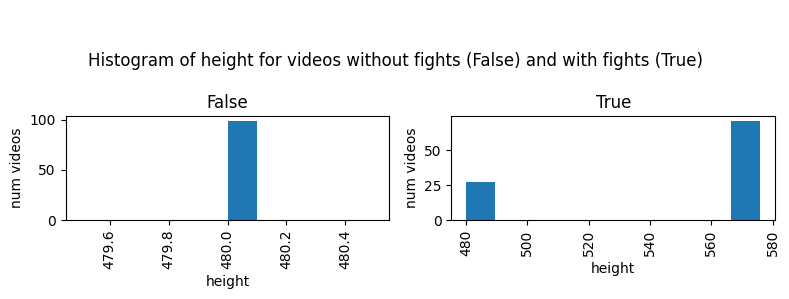

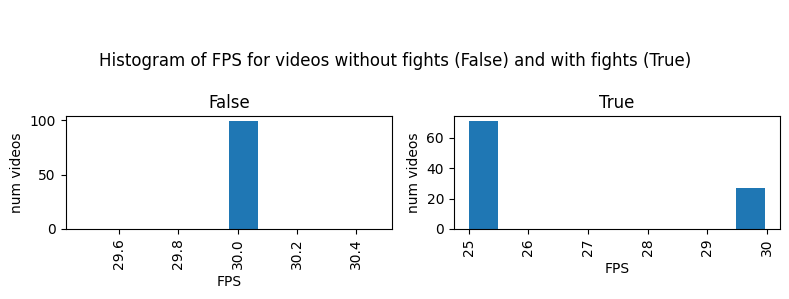

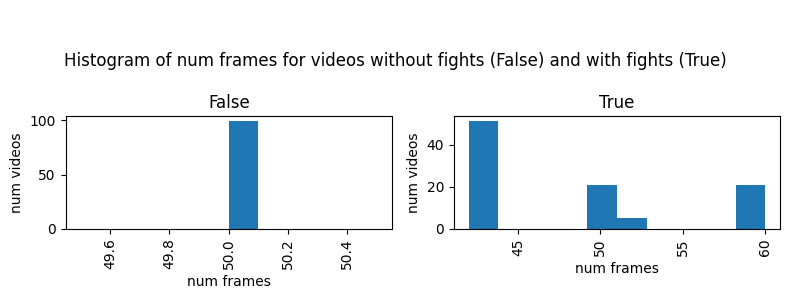

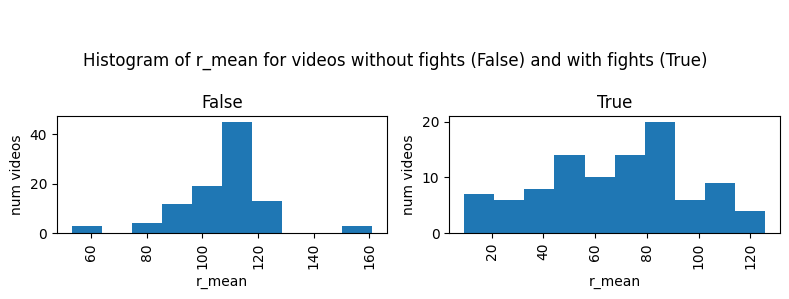

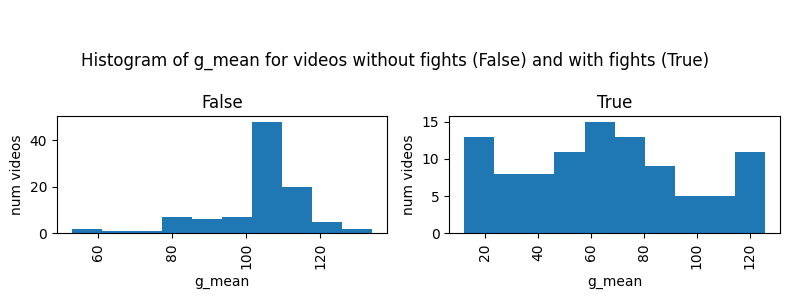

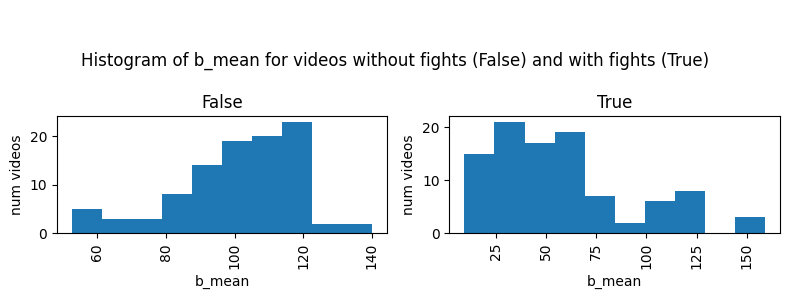

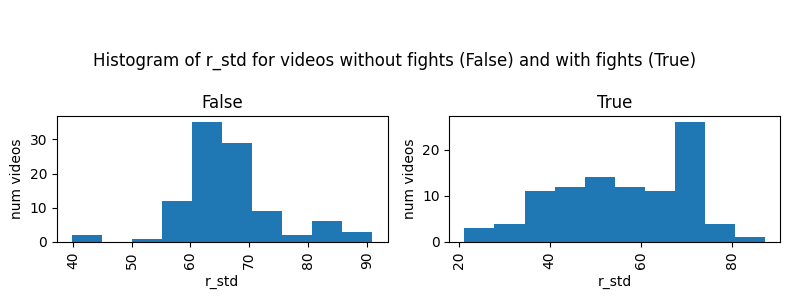

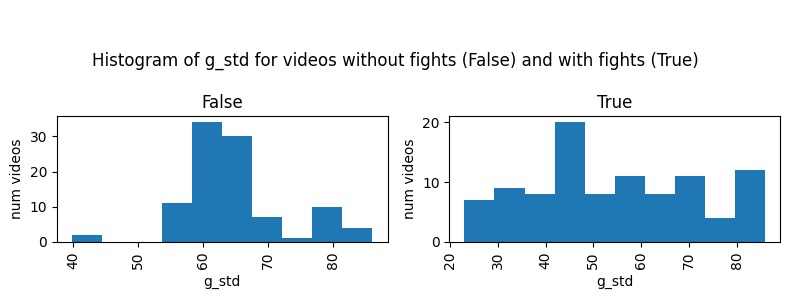

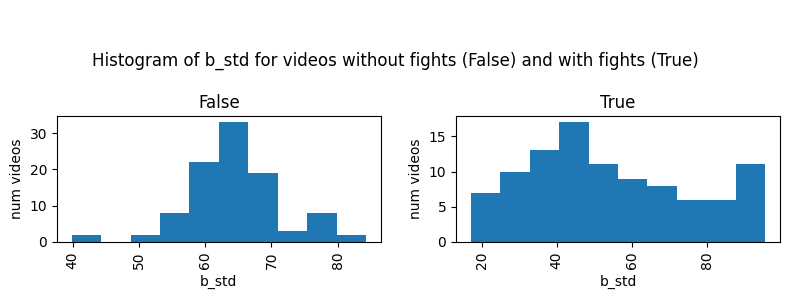

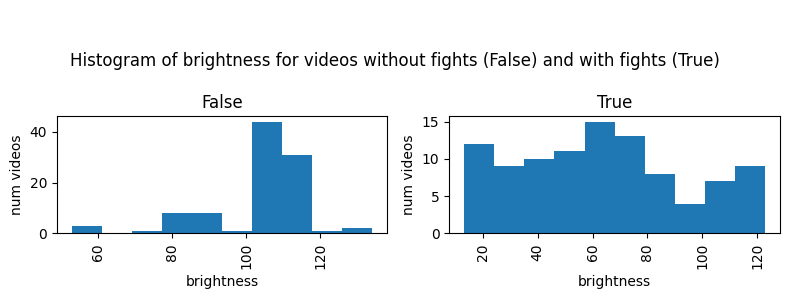

In [163]:
import matplotlib.pyplot as plt

informative_columns = []
for column in props_df.columns:
    unique_values = props_df[column].unique()
    if len(unique_values) == 1 or column in videos_df.columns:
        continue
    informative_columns.append(column)

for i, column in enumerate(informative_columns):
    fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
    fig.suptitle(f"\n\nHistogram of {column} for videos without fights (False) and with fights (True)")
    props_df[column].hist(
        by=props_df['is_fight'], ax=axes, figsize=(4, 2))
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('num videos')
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('num videos')
    plt.tight_layout()


## Digression: video length

Since it was explicitly required in the instructions to display statistics, and the effect of video length on the dataset, we'll do this here. It is not clear whether "video length" referred to the length in the number of frames, or the elapsed time (number of frames / FPS). We will consider the number of frames in the next frame, and the elapsed time in the following.


We can see that all non-fights videos have exactly 50 frames. While most fights videos have 42 frames (with some having 50, 51, or 60 frames). Then, we take the reverse view and see, for each number of frames, the proportion of videos which are from fights. Finally, we can see that classifying videos based uniquely on the number of frames gives us a 89.3% accuracy.

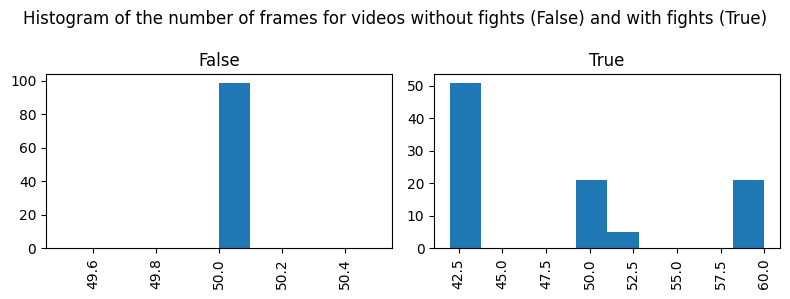

For each number of frames, the proportion of videos which are of fight
            is_fight
num frames          
42.0           1.000
50.0           0.175
51.0           1.000
60.0           1.000


'if num_frames=50 -> not fight, else fight' is correct on 89.3% of the dataset


In [164]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
fig.suptitle(f"Histogram of the number of frames for videos without fights (False) and with fights (True)")
props_df['num frames'].hist(by=props_df['is_fight'], figsize=(4, 2), ax=axes)
plt.tight_layout()
plt.show()

print("For each number of frames, the proportion of videos which are of fight")
prop_of_fights_by_num_frames = props_df.groupby('num frames').agg({'is_fight': 'mean'})
print(prop_of_fights_by_num_frames)

true_negatives = (props_df['num frames'] == 50) & (~props_df['is_fight'])
true_positives = (props_df['num frames'] != 50) & props_df['is_fight']
correctly_classified = true_negatives | true_positives
accuracy = correctly_classified.mean()

print(f"\n\n'if num_frames=50 -> not fight, else fight' is correct on {100*accuracy:.1f}% of the dataset")

# Time elapsed
The elapsed time is even clearer. All videos with fights last more than 1.67 seconds. While only 5.6% of videos without fights do. Thus, a classifier based only on the length (in seconds) of the video, has an accuracy of 97% on the dataset.

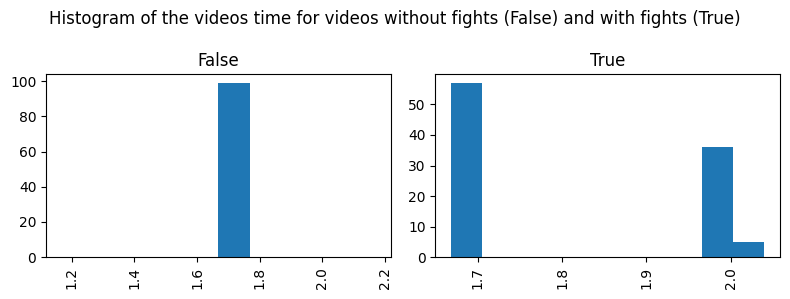

For each time, the proportion of videos which are of fight
          is_fight
time              
1.668333  0.057143
1.680000  1.000000
2.000000  1.000000
2.002000  1.000000
2.040000  1.000000


'if time < 1.67 seconds -> not fight, else fight' is correct on 97.0% of the dataset


In [165]:
props_df['time'] = props_df['num frames'] / props_df['FPS']

fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
fig.suptitle(f"Histogram of the videos time for videos without fights (False) and with fights (True)")
props_df['time'].hist(by=props_df['is_fight'], figsize=(4, 2), ax=axes)
plt.tight_layout()
plt.show()

print("For each time, the proportion of videos which are of fight")
prop_of_fights_by_time = props_df.groupby('time').agg({'is_fight': 'mean'})
print(prop_of_fights_by_time)

true_negatives = (props_df['time'] < 1.67) & (~props_df['is_fight'])
true_positives = (props_df['time'] >= 1.67) & props_df['is_fight']
correctly_classified = true_negatives | true_positives
accuracy = correctly_classified.mean()

print(f"\n\n'if time < 1.67 seconds -> not fight, else fight' is correct on {100*accuracy:.1f}% of the dataset")

## About brightness and contrast

Plotting the average value for red, green, and blue we could notice that:

* Videos with fights are significantly darker than videos without fights. So much that we can classify a video with 84% accuracy by looking only at its brightness. This might hold on larger datasets depending on the source. It might be the case that fight scenes in movies are darker on average than the rest, and this could be a useful (weak) signal to detect fight scenes in movies. But this would be useless to detect a fight during a soccer game / in surveillance cameras / ... So we will use some data augmentation to muddle that signal.
* Even if we normalized brightness, there is also a difference of color balance between fights and non-fights. Fights have less blue.
* There is also a difference in contrast. The standard deviation of red, green, and blue within a video is around 60-70 for most non-fight videos. On the contrary, many fight videos have very low contrast, and many have very high contrast.

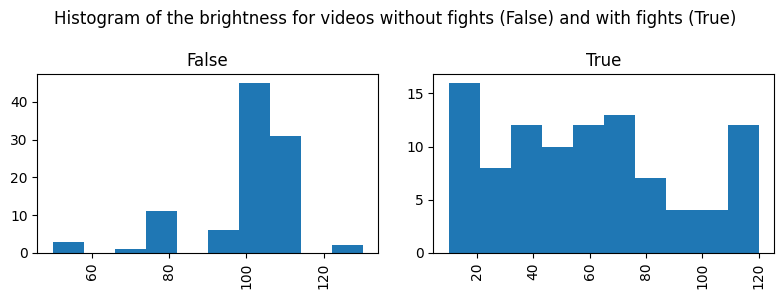

For each time, the proportion of videos which are of fight
                   is_fight
binned_brightness          
10.0               1.000000
20.0               1.000000
30.0               1.000000
40.0               1.000000
50.0               0.769231
60.0               1.000000
70.0               0.928571
80.0               0.388889
90.0               0.400000
100.0              0.081633
110.0              0.243902
120.0              1.000000
130.0              0.000000


'if brightness > 79 -> not fight, else fight' is correct on 84.3% of the dataset


In [166]:
props_df['binned_brightness'] = (props_df['brightness'] // 10) * 10

fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
fig.suptitle(f"Histogram of the brightness for videos without fights (False) and with fights (True)")
props_df['binned_brightness'].hist(by=props_df['is_fight'], figsize=(4, 2), ax=axes)
plt.tight_layout()
plt.show()

print("For each time, the proportion of videos which are of fight")
prop_of_fights_by_time = props_df.groupby('binned_brightness').agg({'is_fight': 'mean'})
print(prop_of_fights_by_time)

true_negatives = (props_df['brightness'] > 79) & (~props_df['is_fight'])
true_positives = (props_df['brightness'] <= 79) & props_df['is_fight']
correctly_classified = true_negatives | true_positives
accuracy = correctly_classified.mean()

print(f"\n\n'if brightness > 79 -> not fight, else fight' is correct on {100*accuracy:.1f}% of the dataset")

In [167]:
fight_rows = props_df[props_df['is_fight']]
fight_rel_blue = (fight_rows['b_mean'] - fight_rows['brightness']).mean()

non_fight_rows = props_df[~props_df['is_fight']]
non_fight_rel_blue = (non_fight_rows['b_mean'] - non_fight_rows['brightness']).mean()

print(f'Blue difference with brightness is {fight_rel_blue} for fights, and {non_fight_rel_blue}')

Blue difference with brightness is -6.807310877778141 for fights, and -3.5520387975043652


## About frame height
All non-fight videos have a height of 480, while most fight videos have a height of 576. This is something we need to be careful about when writing the preprocessing for our classifier.


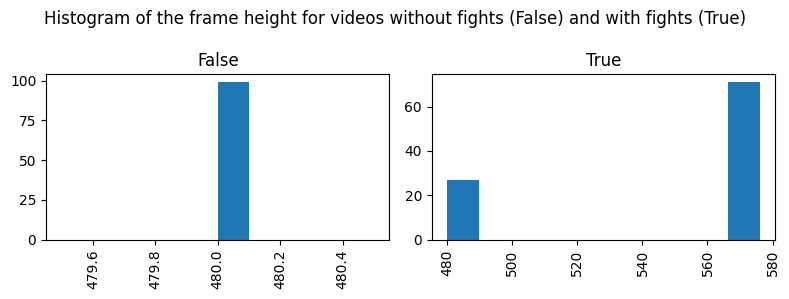

For each number of frames, the proportion of videos which are of fight
        is_fight
height          
480.0   0.214286
576.0   1.000000


'if height < 500px -> not fight, else fight' is correct on 86.3% of the dataset


In [168]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
fig.suptitle(f"Histogram of the frame height for videos without fights (False) and with fights (True)")
props_df['height'].hist(by=props_df['is_fight'], figsize=(4, 2), ax=axes)
plt.tight_layout()
plt.show()

print("For each number of frames, the proportion of videos which are of fight")
prop_of_fights_by_num_frames = props_df.groupby('height').agg({'is_fight': 'mean'})
print(prop_of_fights_by_num_frames)

true_negatives = (props_df['height'] < 500) & (~props_df['is_fight'])
true_positives = (props_df['height'] >= 500) & props_df['is_fight']
correctly_classified = true_negatives | true_positives
accuracy = correctly_classified.mean()

print(f"\n\n'if height < 500px -> not fight, else fight' is correct on {100*accuracy:.1f}% of the dataset")

## A model based on videos meta-properties

Let us write a classifier based on those properties. I do not seriously think it is a useful classifier. However, I am writing it for 2 reasons:

* It is a measure of the imbalances of the dataset. Those features should not be enough to decide whether there is a fight or not, those are spurious correlation. And we will have to remove them during preprocessing to avoid Clever Hans effects.
* The instructions are asking "Display usage of some feature importance and model explainability techniques". While I have methods for model explainability in deep learning, I am not sure that "feature importance" makes much sense for the approach I took. Therefore, I chose to display the usage here.

We choose a model based on decision trees because they are simple to understand and can deal with categorical features. Even though every feature we have is numerical, we think some of them ('FPS', 'height', 'num_frames') are better seen as categorical: "num frames"=50 is indicative of "non-fight" in this dataset. But there is no reason to believe that values of "num_frames" close to 50 are also indicative of "non-fight".

We choose random forest in particular because they can deal with many weak indicators without overly relying on one particular feature.

Precision = 0.93 (std=0.20)
Recall = 0.95 (std=0.10)
F1-score = 0.92 (std=0.15)



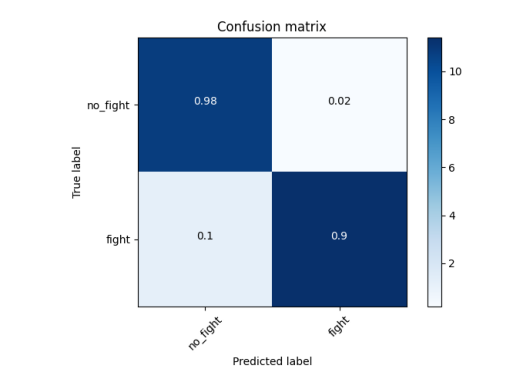

In [222]:
import sklearn
import sklearn.inspection

from fight_classifier.data.data_split import split_based_on_column
from fight_classifier.visualization import imshow_chw
from fight_classifier.visualization.metrics import plot_confusion_matrix

# We will collect the metrics for various dataset splits
# and average them.
confusion_matrices = []
f1_scores = []
precisions = []
recalls = []

features_impurity_importances = []
features_permutation_importances = []

for random_seed in range(10):
    # Generate a random dataset split
    dataset_split = split_based_on_column(
        data=props_df, col_name='fine_category', random_seed=random_seed)
    train_dataset = dataset_split['train'].astype({
        "height": str, "FPS": str, 'num frames': str})
    val_dataset = dataset_split['val'].astype({
        "height": str, "FPS": str, 'num frames': str})


    # Train a random forest on the train dataset
    features_columns = [
        'height', 'FPS', 'num frames', 'time',
        # 'r_mean', 'g_mean', 'b_mean',
        'brightness',
        'r_std', 'g_std', 'b_std']
    train_features = train_dataset[features_columns]
    train_groundtruth = train_dataset['is_fight']
    rf = sklearn.ensemble.RandomForestClassifier()
    rf.fit(train_features, train_groundtruth)

    # Run the random forest on the validation dataset
    val_features = val_dataset[features_columns]
    val_groundtruth = val_dataset['is_fight']
    val_predictions = rf.predict(val_features)

    # Compute the confusion matrix and derive metrics from it.
    #  (i, j): number of samples with groundtruth=i, and predicted=j
    confusion_matrix = sklearn.metrics.confusion_matrix(
        y_true=val_groundtruth, y_pred=val_predictions)
    precision = confusion_matrix[1,1] / confusion_matrix[:,1].sum()
    recall = confusion_matrix[1,1] / confusion_matrix[1,:].sum()
    f1_score = 2 * precision * recall / (precision+recall)
    
    confusion_matrices.append(confusion_matrix)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    
    # Compute the feature importances according to 2 methods
    perm_importance = sklearn.inspection.permutation_importance(
        estimator=rf, X=val_features, y=val_groundtruth, n_repeats=10)
    features_permutation_importances.append(perm_importance.importances_mean)
    features_impurity_importances.append(rf.feature_importances_)

print(
    f"Precision = {np.mean(precisions):.2f} (std={np.std(precisions):.2f})\n"
    f"Recall = {np.mean(recalls):.2f} (std={np.std(recalls):.2f})\n"
    f"F1-score = {np.mean(f1_scores):.2f} (std={np.std(f1_scores):.2f})\n"
)
average_confusion_matrix = np.mean(confusion_matrices, axis=0)
cm_viz_chw = plot_confusion_matrix(
    cm=average_confusion_matrix, class_names=['no_fight', 'fight'])
fig, ax = plt.subplots()
ax.set_axis_off()
imshow_chw(img_chw=cm_viz_chw)
plt.show()

## Measuring feature importance

We measure importance in 2 ways: 
* Impurity importance indicates how useful each feature was to decrease the entropy when creating the random forest.
* Permutation importance indicates how much worse validation accuracy becomes if we replace each feature with another.

Both measures show that "time" is an especially important feature, followed by "brightness".

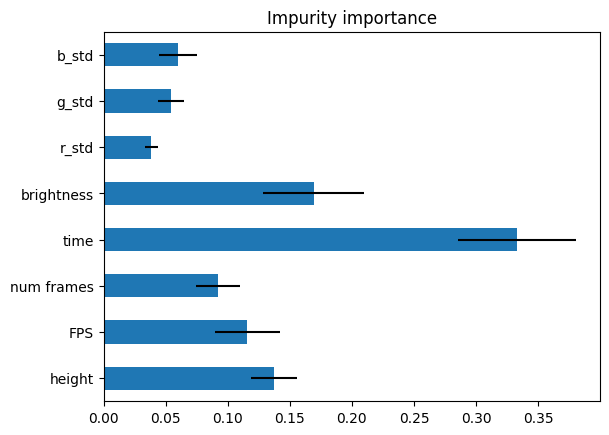

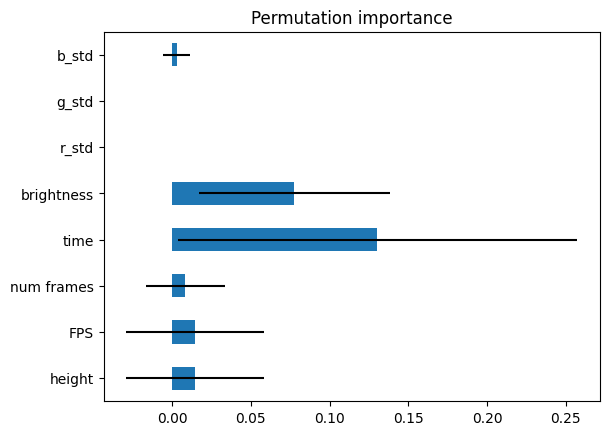

In [223]:
avg_impurity_importance = pd.Series(
    np.mean(features_impurity_importances, axis=0),
    index=features_columns)
std_impurity_importance = np.std(
    features_impurity_importances, axis=0)
plt.Figure()
plt.title('Impurity importance')
avg_impurity_importance.plot.barh(xerr=std_impurity_importance)
plt.show()

avg_permutation_importance = pd.Series(
    np.mean(features_permutation_importances, axis=0),
    index=features_columns)
std_permutation_importance = np.std(
    features_permutation_importances, axis=0)
plt.Figure()
plt.title('Permutation importance')
avg_permutation_importance.plot.barh(xerr=std_permutation_importance)
plt.show()

## Model display
Finally, we can display some of the 100 trees of the random forest. Since there are so many trees, it's hard to understand the full model like that, but it gives an idea of how each video is classified.

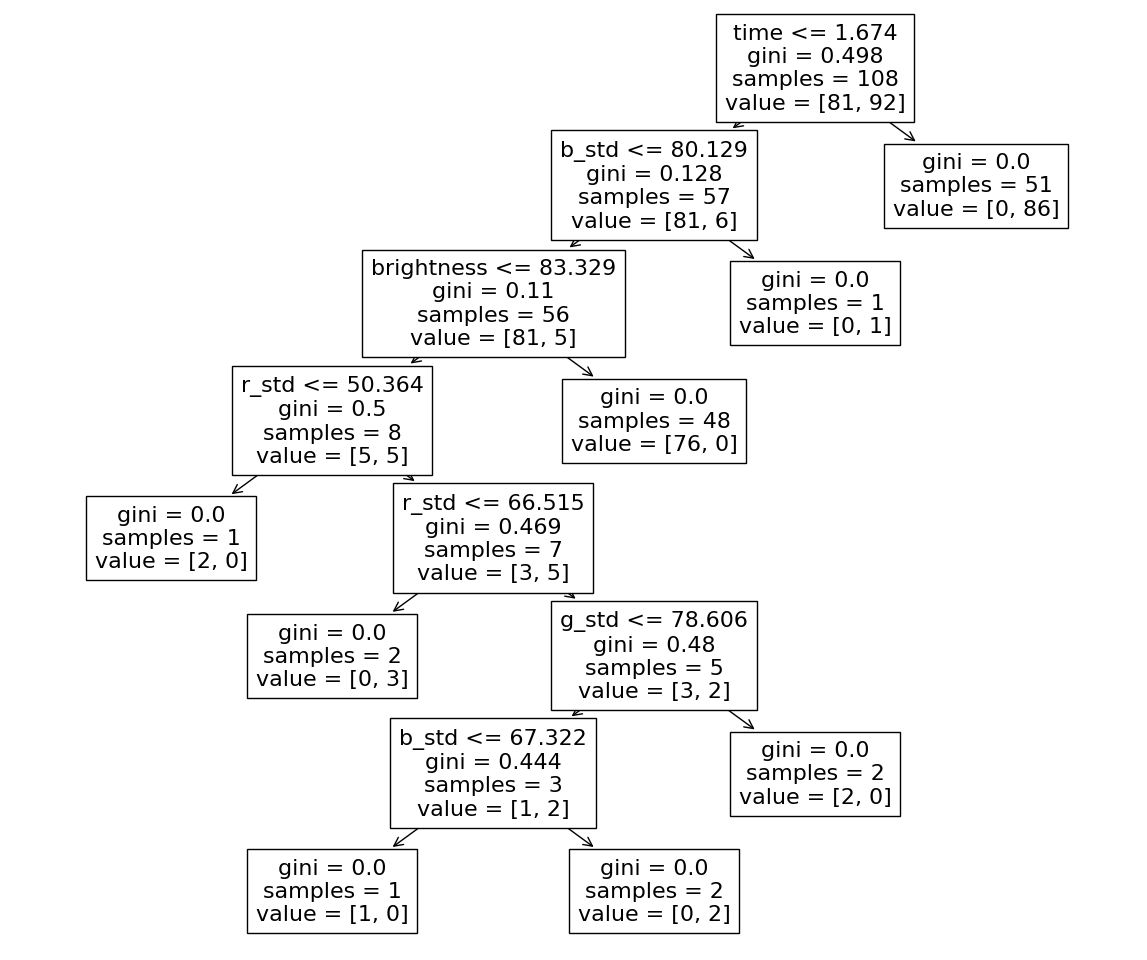

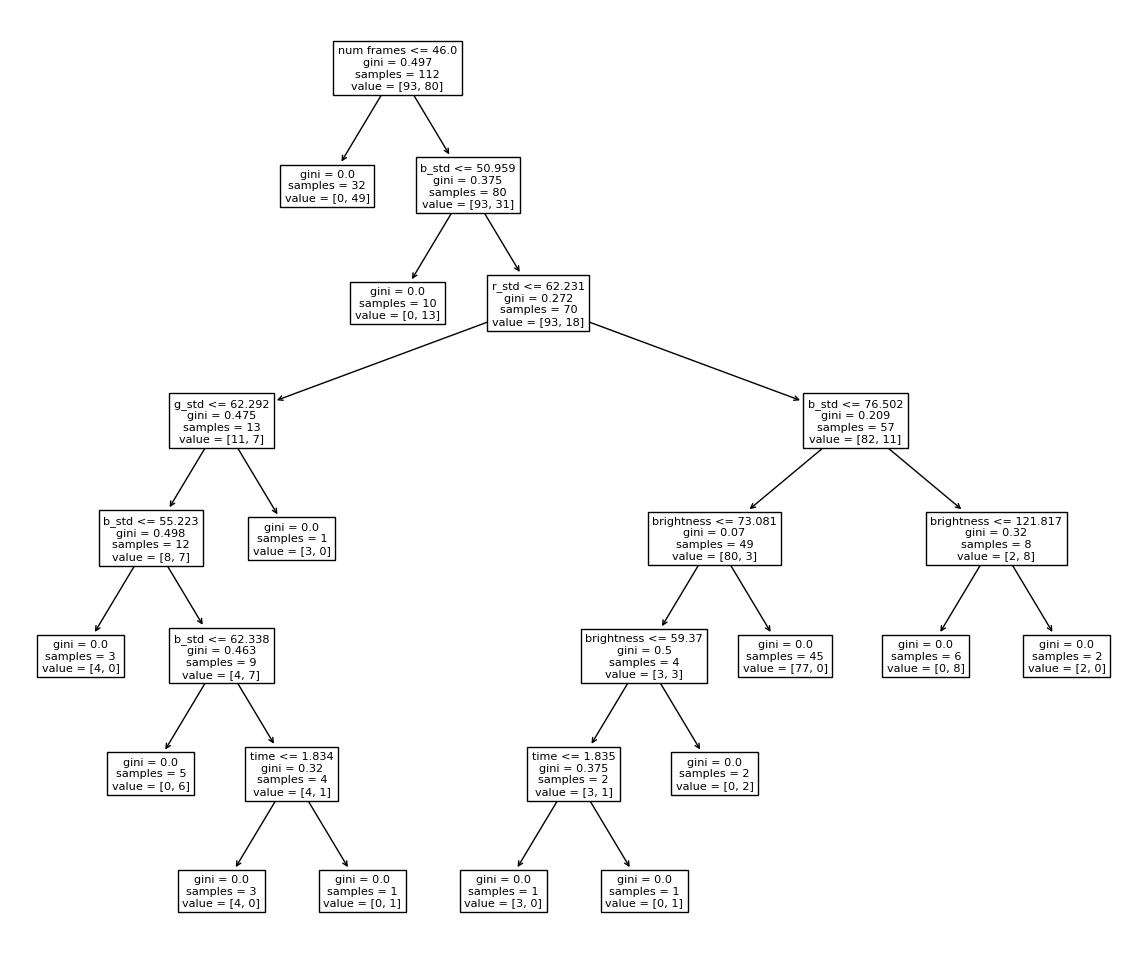

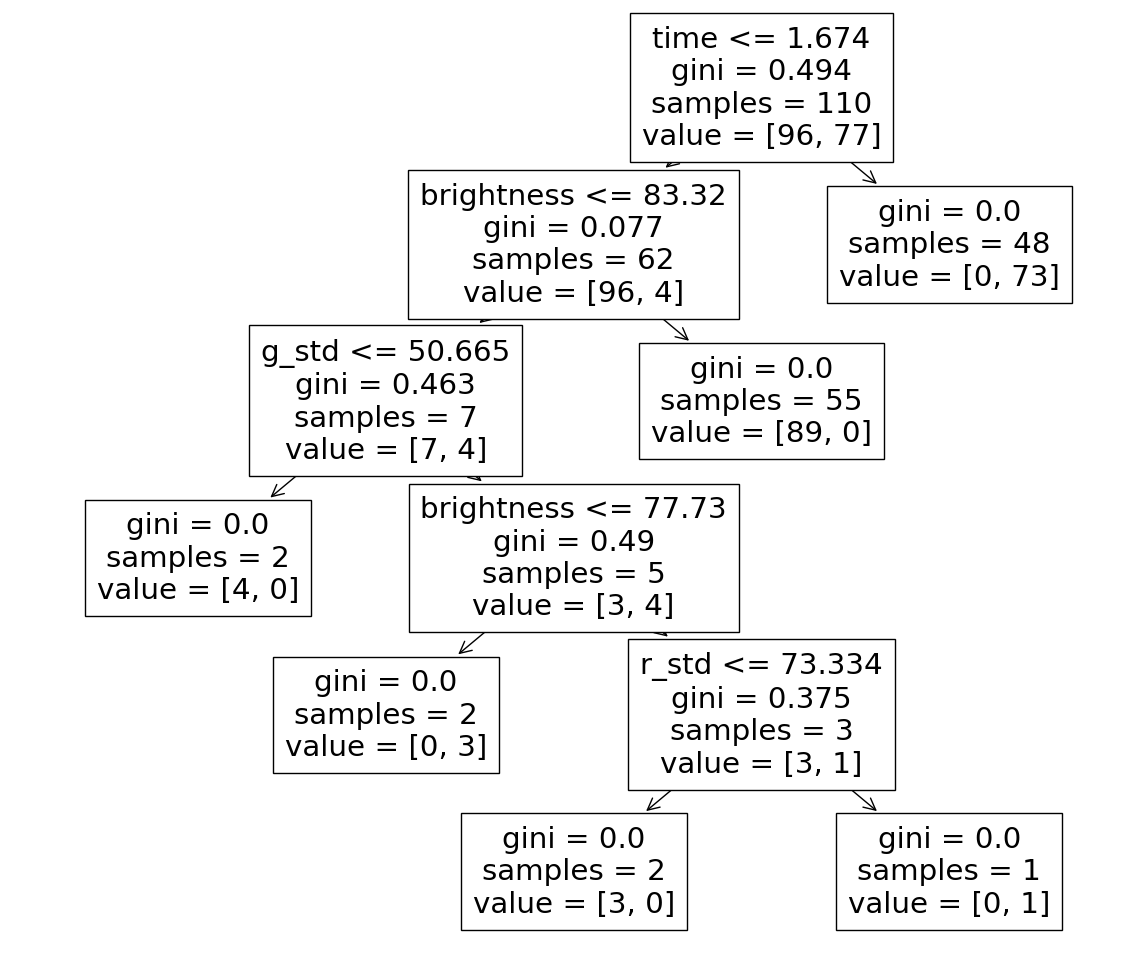

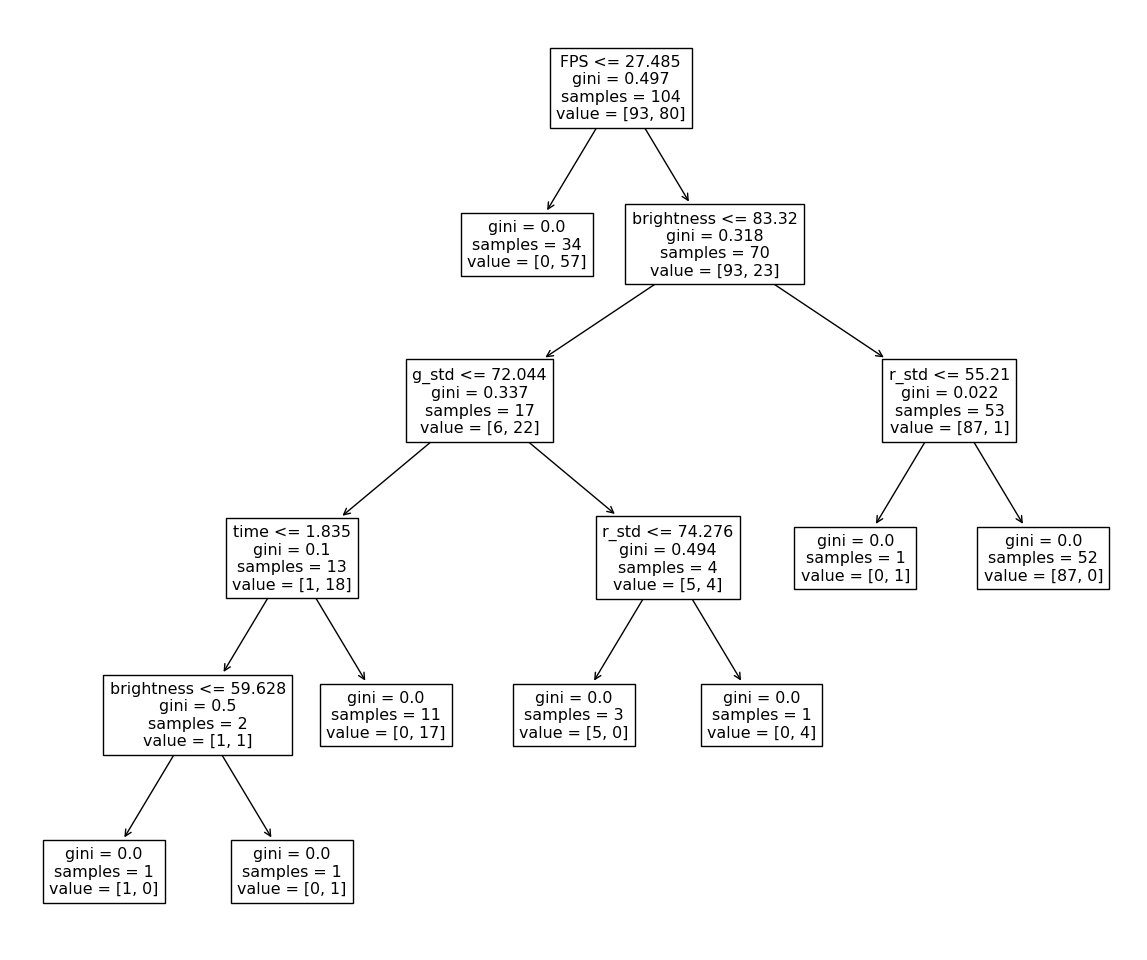

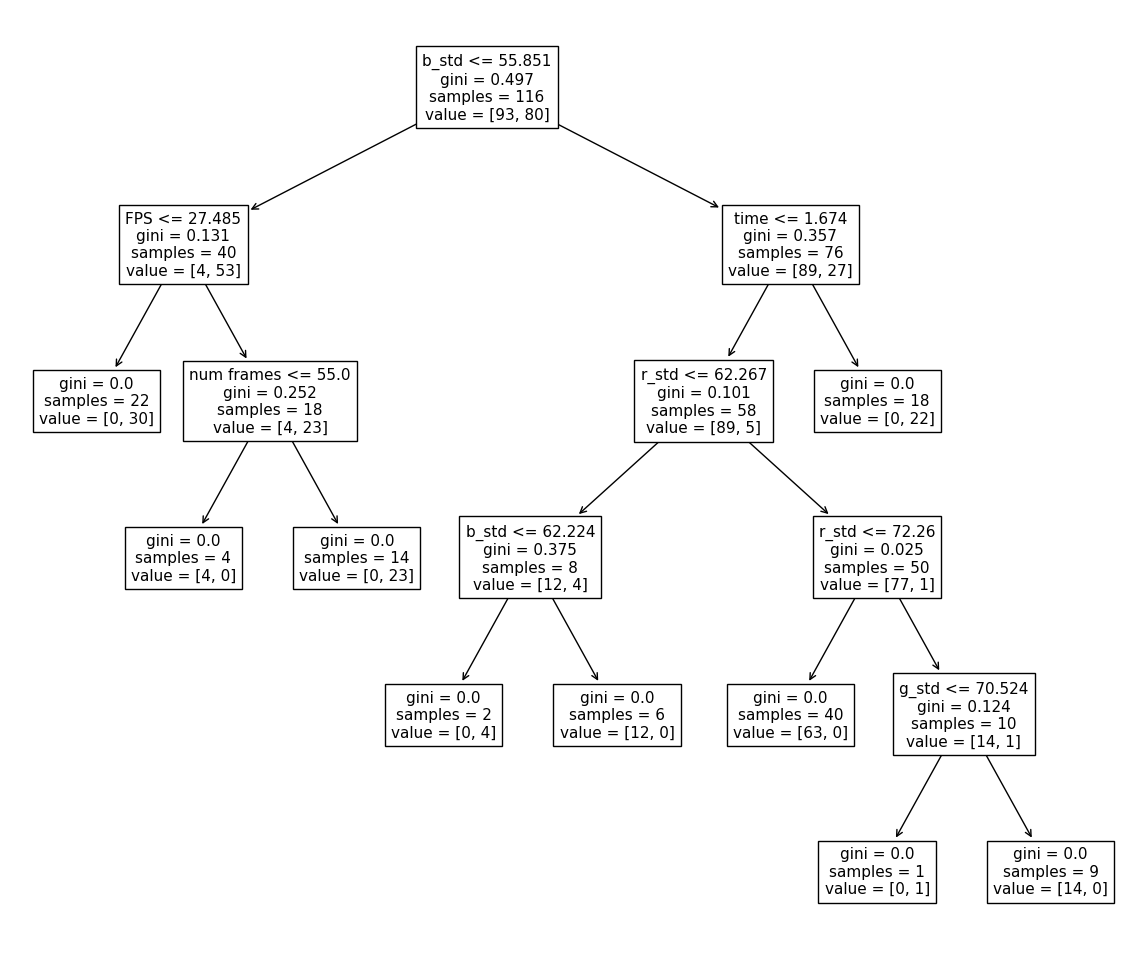

In [235]:
from sklearn import tree

for tree_id in range(5):
    fig, ax = plt.subplots(figsize=(12, 10))
    plt.tight_layout()
    tree.plot_tree(rf.estimators_[tree_id], feature_names=features_columns, ax=ax)
    plt.show()

In [241]:
import joblib

features_columns = [
    'height', 'FPS', 'num frames', 'time',
    # 'r_mean', 'g_mean', 'b_mean',
    'brightness',
    'r_std', 'g_std', 'b_std']


def classify_from_path(path):
    prop_dict = get_video_properties(path)
    video = skvideo.io.vread(str(path))
    brightness = np.mean(video)
    r_std, g_std, b_std = np.std(video, axis=(0, 1, 2))

    video_features = np.array([[
        prop_dict['height'],
        prop_dict['FPS'],
        prop_dict['num frames'],
        prop_dict['num frames'] / prop_dict['FPS'],
        brightness,
        r_std,
        g_std,
        b_std,
    ]])
    fight_proba = rf.predict_proba(video_features)
    return fight_proba

print(str(fights_paths[0]))
classify_from_path(str(fights_paths[0]))

/home/matthieu/aviva/hiring-challenge/dataset/Peliculas/fights/newfi31.avi


/home/matthieu/aviva/hiring-challenge/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.02, 0.98]])

# Save the model with joblib

In [243]:
from fight_classifier import PROJECT_DIR

joblib_dump_path = str(PROJECT_DIR / 'joblib_random_forest')
joblib.dump(value=rf, filename=joblib_dump_path)

['/home/matthieu/aviva/hiring-challenge/joblib_random_forest']